In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f_xstar(lij,lpij,luv,muv,mvu,d):
  xstar = np.zeros([m,m,2,1])
  bal = np.zeros([m,m,ne,xp])
  #print(muv-mvu)
  for i in range(3):
      for j in range(3):
        if i!=j :
          for k in range(2):
            if j>i:
              bal[i,j,:,k]=c[i,j,:,k]
            elif j<i:
              bal[i,j,:,k]=-c[i,j,:,k]
            xstar[i,j,k]=((1)/((lij[i,j] - lpij[i,j,k] + (c[i,j,:,k])@luv + c_bal[i,j,:,k]@(muv-mvu) )*np.log2(10))).reshape([1])
             
            #print(np.sum(bal[i,j,:,k]) )
            if xstar[i,j,k]>d[i,j]or xstar[i,j,k]==np.inf:
              xstar[i,j,k]=d[i,j]
            if xstar[i,j,k]<0 :
              xstar[i,j,k]=0.0000000000001

  return xstar


In [3]:
def update(xstar,lij,lpij,luv,muv,mvu,alpha):
  for i in range(3):
    for j in range(3):
      if i!=j:
        lij[i,j]=lij[i,j]+alpha *(np.sum(xstar[i,j])-d[i,j])
        if lij[i,j]<0:
          lij[i,j]=0.0
  for i in range(3):
    for j in range(3):
      if i!=j:
        for k in range(2):
          lpij[i,j,k]=lpij[i,j,k]-alpha*xstar[i,j,k]
          if lpij[i,j,k]<0:
            lpij[i,j,k]=0.0
  s =c@xstar +(c@xstar).transpose(1,0,2,3) 
  sn =c_bal@xstar +(c_bal@xstar).transpose(1,0,2,3) 
  sn_ =-c_bal@xstar - (c_bal@xstar).transpose(1,0,2,3) 
  gluv =np.array([[0.],[0.],[0.]])
  gmuv =np.array([[0.],[0.],[0.]])
  gmvu =np.array([[0.],[0.],[0.]])
  for i in range(3):
    for j in range(3):
      if j>i :
        for k in range(ne):
          gluv[k]+=s[i,j,k]
          gmuv[k]+=sn[i,j,k]
          gmvu[k]+=sn_[i,j,k]
  for k in range(ne):
    luv[0,0,k]= luv[0,0,k] +alpha*(gluv[k]-CA[k])
    if luv[0,0,k]<0:
      luv[0,0,k]=0
    muv[0,0,k]= muv[0,0,k] + alpha*(gmuv[k])
    #print(muv,"\n-----------")
    mvu[0,0,k]= mvu[0,0,k] + alpha*(gmvu[k])
    if muv[0,0,k]<0 :
      muv[0,0,k]=0
    if mvu[0,0,k]<0 :
      mvu[0,0,k]=0
  return lij,lpij,luv,muv,mvu

In [4]:
def sum_log(x,d,lij,lpij,c,bal,luv,CA,muv):
  yy=[]
  for i in range(m):
    for j in range(m):
      if i!=j :
        yy+=[[[True],[True]]]
      else:
        x[i,j]=np.array([[np.nan],[np.nan]])
        yy+=[[[False],[False]]]
  yy=np.array(yy).reshape([m,m,2,1])
  for i in range(3):
    for j in range(3):
      for k in range(2):
        if i!=j :
          if x[i,j,k]==0:
            x[i,j]=0.00001
  ret =(np.sum(np.log10(x),where=yy))
  return

In [5]:
def lagranzh(x,d,lij,lpij,c,bal,luv,CA,muv):
  yyy=[]
  y = []
  yy=[]
  for i in range(m):
    for j in range(m):
      if i!=j :
        y+=[[[True]]]
        yy+=[[[True],[True]]]
        if i>j :
          yyy+=[[[True],[True],[True]]]
        else:
          yyy+=[[[False],[False],[False]]]
      else:
        x[i,j]=np.array([[np.nan],[np.nan]])
        y+=[[[False]]]
        yy+=[[[False],[False]]]
        yyy+=[[[False],[False],[False]]]
  y=np.array(y).reshape([m,m,1,1])
  yy=np.array(yy).reshape([m,m,2,1])
  yyy=np.array(yyy).reshape([m,m,3,1])
  for i in range(3):
    for j in range(3):
      for k in range(2):
        if i!=j :
          if x[i,j,k]==0:
            x[i,j]=0.00001
  ret =(np.sum(np.log10(x),where=yy))
  #+np.sum( lij * (x.reshape([3,3,1,2]) @ np.array([1,1]).reshape([1,1,2,1]) - d).reshape([3,3]) ,where=y.reshape([m,m]) ) 
  #- np.sum(lpij * x ,where=yy) 
  #+ np.sum((c@x +(c@x).transpose(1,0,2,3) ) * luv ,where=yyy) -np.sum(CA) 
  #+ np.sum((c@x -(c@x).transpose(1,0,2,3)) * muv , where = yyy))
  return ret

In [25]:
import math
m=3
ne=3
xp=2
rand= np.random.default_rng(seed=42)
#x = 5*rand.random([m,m,2,1])+5
d = np.zeros([m,m,1,1])
c = np.zeros([m,m,ne,xp])
c_bal = np.zeros([m,m,ne,xp])
CA = np.array([20,20,20])
path = np.array([[[1,0],[0,1],[0,1]],[[0,1],[1,0],[0,1]],[[0,1],[0,1],[1,0]]])
path_bal = np.array([[[1,0],[0,1],[0,1]],[[0,1],[1,0],[0,-1]],[[0,-1],[0,1],[-1,0]]])
#path_bal = np.array([[[1,0],[0,1],[0,1]],[[0,1],[1,0],[0,1]],[[0,1],[0,1],[1,0]]])
lij=rand.random([m,m])
luv =rand.random([ne]).reshape(1,1,3,1)
muv =rand.random([ne]).reshape(1,1,3,1)
mvu =muv
lpij =rand.random((3,3,2,1))

d0=20
for i in range(m):
  for j in range(m):
    if i!=j :
      d[i,j]=np.array([[d0]])
      if i>j :
        if i+j==1:
          c_bal[i,j]=-path_bal[0]
          c_bal[j,i]=path_bal[0]
        if i+j==2:
          c_bal[i,j]=-path_bal[1]
          c_bal[j,i]=path_bal[1]
        if i+j==3:
          c_bal[i,j]=-path_bal[2]
          c_bal[j,i]=path_bal[2]
      if i+j ==1:
        c[i,j]= path[0]
      elif i+j ==2 :
        c[i,j]=path[1]
      elif i+j ==3 :
        c[i,j]=path[2]
    else:
      #x[i,j]=np.array([[np.nan],[np.nan]])
      d[i,j]=np.array([[np.nan]])

y=[]
Y=[]
for n in range(100000):
  alpha=1/(math.sqrt(n+1))
  #print(muv-mvu,'\n','---------------')
  xstar=f_xstar(lij,lpij,luv,muv,mvu,d)
  Y+=[lagranzh(xstar,d,lij,lpij,c,c_bal,luv,CA,muv)]
  #print(lij,lagranzh(xstar,d,lij,lpij,c,luv,CA,muv))
  y+=[xstar]
  lij,lpij,luv,muv,mvu=update(xstar,lij,lpij,luv,muv,mvu,alpha)
y = np.array(y)
Y = np.array(Y)
y.shape,Y.shape

<ipython-input-2-355d5b2c299c>:13: RuntimeWarning: divide by zero encountered in true_divide
  xstar[i,j,k]=((1)/((lij[i,j] - lpij[i,j,k] + (c[i,j,:,k])@luv + c_bal[i,j,:,k]@(muv-mvu) )*np.log2(10))).reshape([1])


((100000, 3, 3, 2, 1), (100000,))

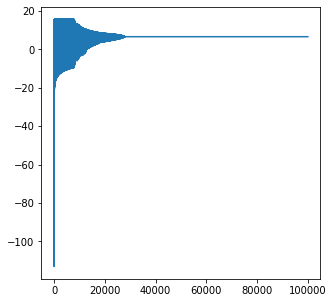

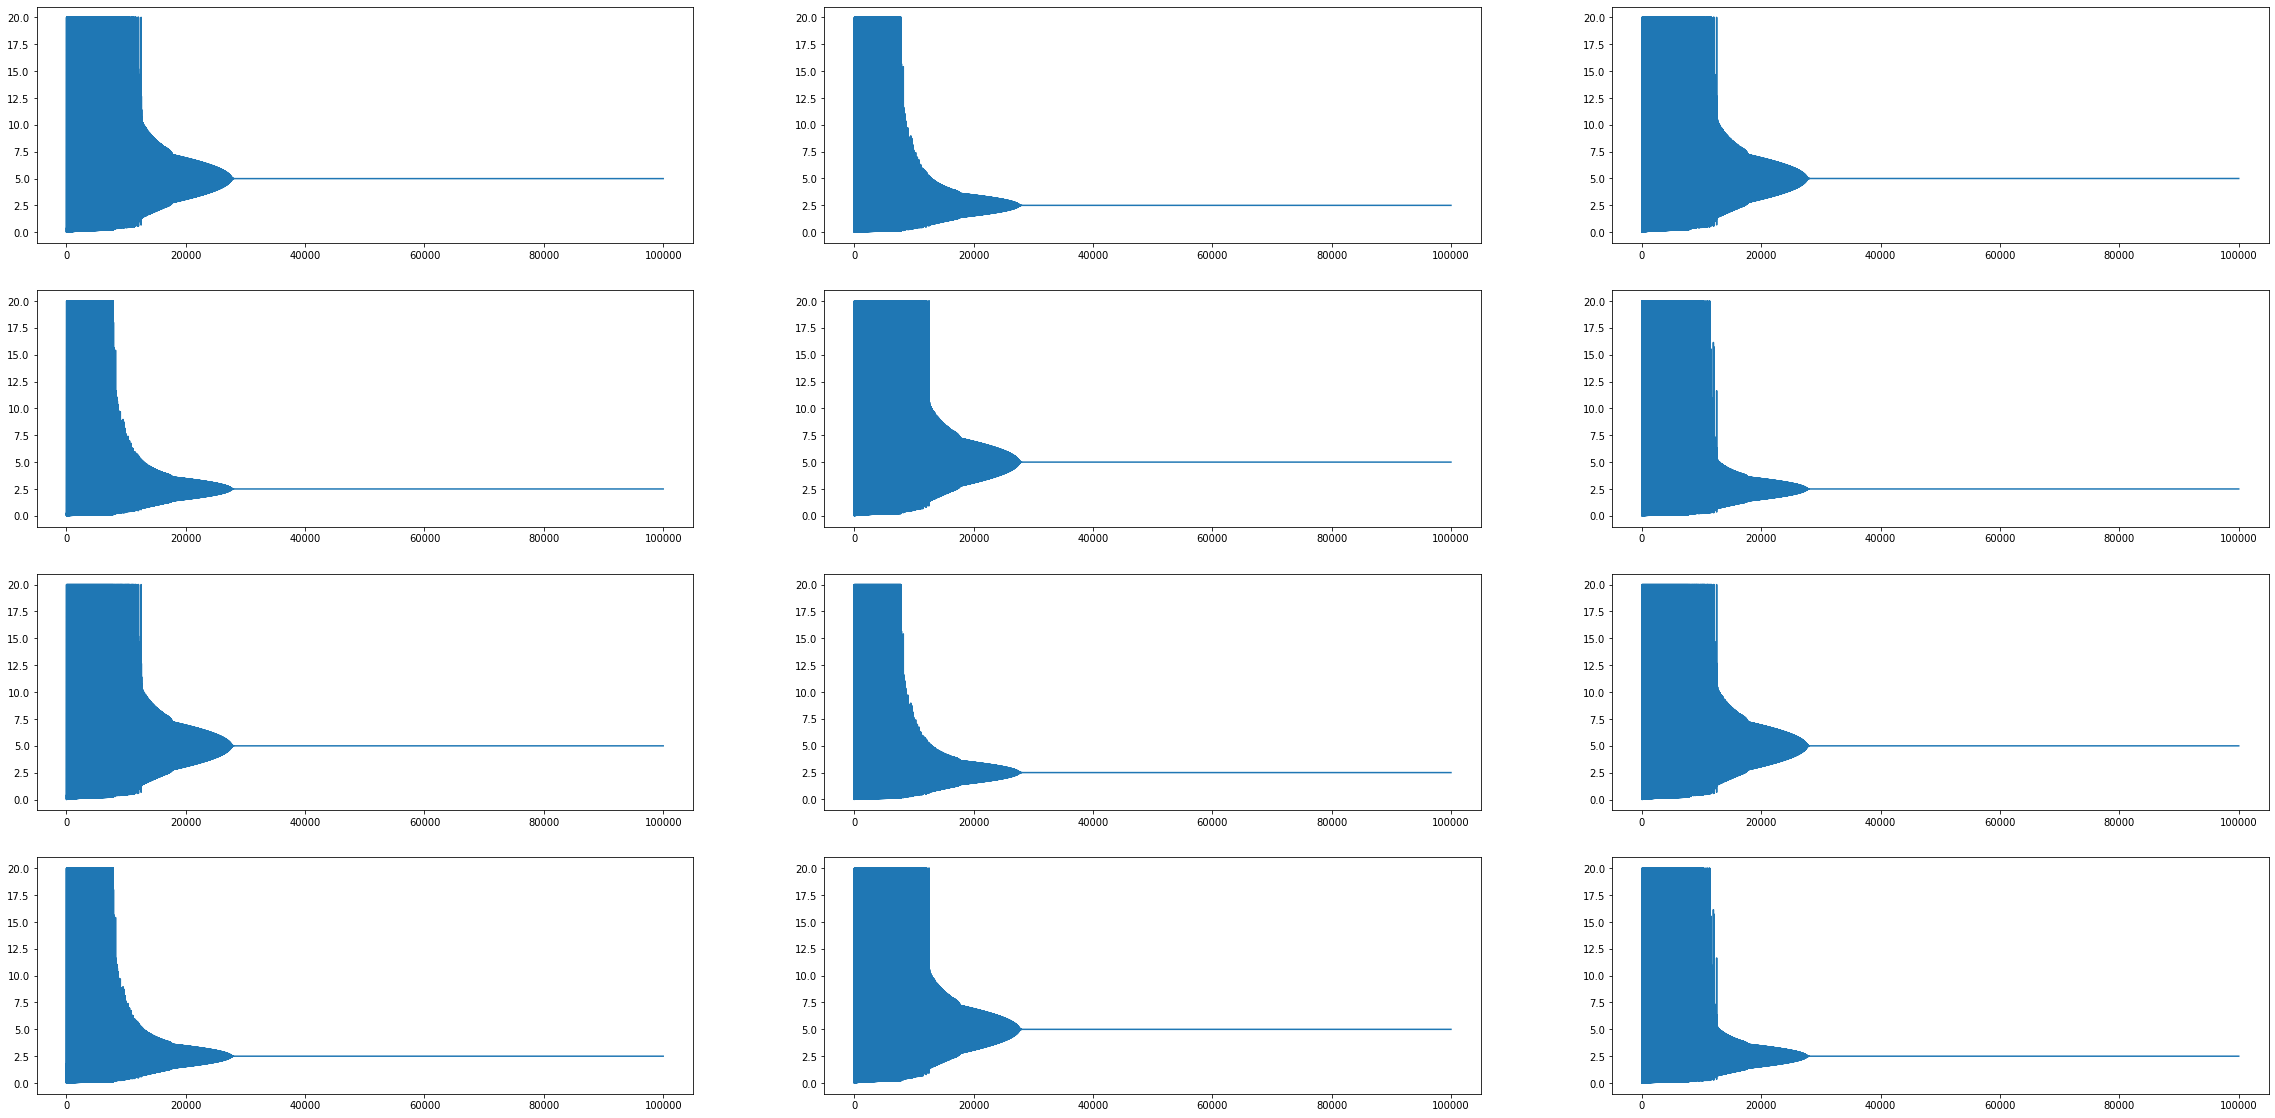

In [26]:
x = np.linspace(0,100000, 100000)
f2 = plt.figure()
f2.set_figwidth(5)
f2.set_figheight(5)
plt.plot(x,Y)
plt.show()

#plt.plot(x,y[:,0,1,0],y[:,0,1,1],y[:,0,2,0],y[:,0,2,1],y[:,1,2,0],y[:,1,2,1])
f = plt.figure()
f.set_figwidth(20/.5)
f.set_figheight(10/.5)
plt.subplot(4, 3, 1,)
plt.plot(x,y[:,0,1,0])
plt.subplot(4, 3, 2)
plt.plot(x,y[:,0,1,1])

plt.subplot(4, 3, 3)
plt.plot(x,y[:,0,2,0])

plt.subplot(4, 3, 4)
plt.plot(x,y[:,0,2,1])

plt.subplot(4, 3, 5)
plt.plot(x,y[:,1,2,0])


plt.subplot(4, 3, 6)
plt.plot(x,y[:,1,2,1])

plt.subplot(4, 3, 7)
plt.plot(x,y[:,1,0,0])
plt.subplot(4, 3, 8)
plt.plot(x,y[:,1,0,1])

plt.subplot(4, 3, 9)
plt.plot(x,y[:,2,0,0])

plt.subplot(4, 3, 10)
plt.plot(x,y[:,2,0,1])

plt.subplot(4, 3, 11)
plt.plot(x,y[:,2,1,0])


plt.subplot(4, 3, 12)
plt.plot(x,y[:,2,1,1])
plt.show()

In [14]:
def f_xstar_agent(i,j,k,lij,lpij,luv,muv,mvu,d):
  if lij[i,j] - lpij[i,j,k]+ (c[i,j,:,k])@luv + c_bal[i,j,:,k]@(muv-mvu)==0:
    xstar=d[i,j]
  else:
    xstar=((1)/((lij[i,j] - lpij[i,j,k]+ (c[i,j,:,k])@luv + c_bal[i,j,:,k]@(muv-mvu) )*np.log2(10))).reshape([1])
  if xstar>d[i,j]:
    xstar=d[i,j]
  if xstar<=0 :
    xstar=0.0000000000001
  return xstar

In [15]:
f_xstar_agent(i,j,k,lij,lpij,luv,muv,mvu,d)

NameError: ignored

In [16]:
def co_update(xstar,lij,lpij,luv,muv,mvu,n):
  alpha=1/(n+1)
  for i in range(3):
    for j in range(3):
      if i!=j:
        lij[i,j]=lij[i,j]+alpha *(np.sum(xstar[i,j])-d[i,j])
        if lij[i,j]<0:
          lij[i,j]=0.0
  for i in range(3):
    for j in range(3):
      if i!=j:
        for k in range(2):
          lpij[i,j,k]=lpij[i,j,k]-alpha*xstar[i,j,k]
          if lpij[i,j,k]<0:
            lpij[i,j,k]=0.0
  s =c@xstar +(c@xstar).transpose(1,0,2,3) 
  sn =c_bal@xstar +(c_bal@xstar).transpose(1,0,2,3) 
  sn_ =-c_bal@xstar - (c_bal@xstar).transpose(1,0,2,3) 
  gluv =np.array([[0.],[0.],[0.]])
  gmuv =np.array([[0.],[0.],[0.]])
  gmvu =np.array([[0.],[0.],[0.]])
  for i in range(3):
    for j in range(3):
      if j>i :
        for k in range(ne):
          gluv[k]+=s[i,j,k]
          gmuv[k]+=sn[i,j,k]
          gmvu[k]+=sn_[i,j,k]
  for k in range(ne):
    luv[0,0,k]= luv[0,0,k] +alpha*(gluv[k]-CA[k])
    if luv[0,0,k]<0:
      luv[0,0,k]=0
    muv[0,0,k]= muv[0,0,k] + alpha*(gmuv[k])
    #print(muv,"\n-----------")
    mvu[0,0,k]= mvu[0,0,k] - alpha*(gmvu[k])
    if muv[0,0,k]<0 :
      muv[0,0,k]=0
    if mvu[0,0,k]<0 :
      mvu[0,0,k]=0
  return lij,lpij,luv,muv,mvu

In [17]:
def sum_log(x):
  yy=[]
  for i in range(m):
    for j in range(m):
      if i!=j :
        yy+=[[[True],[True]]]
      else:
        x[i,j]=np.array([[np.nan],[np.nan]])
        yy+=[[[False],[False]]]
  yy=np.array(yy).reshape([m,m,2,1])
  for i in range(3):
    for j in range(3):
      for k in range(2):
        if i!=j :
          if x[i,j,k]==0:
            x[i,j]=0.00001
  ret =(np.sum(np.log10(x),where=yy))
  return ret

In [18]:
m=3
ne=3
xp=2
rand= np.random.default_rng(seed=42)
#x = 5*rand.random([m,m,2,1])+5
d = np.zeros([m,m,1,1])
c = np.zeros([m,m,ne,xp])
c_bal = np.zeros([m,m,ne,xp])
CA = np.array([20,20,20])
path = np.array([[[1,0],[0,1],[0,1]],[[0,1],[1,0],[0,1]],[[0,1],[0,1],[1,0]]])
path_bal = np.array([[[1,0],[0,1],[0,1]],[[0,1],[1,0],[0,-1]],[[0,-1],[0,1],[-1,0]]])
#path_bal = np.array([[[1,0],[0,1],[0,1]],[[0,1],[1,0],[0,1]],[[0,1],[0,1],[1,0]]])
lij=rand.random([m,m])
luv =rand.random([ne]).reshape(1,1,3,1)
muv =rand.random([ne]).reshape(1,1,3,1)
mvu =muv
lpij =rand.random((3,3,2,1))

d0=20
for i in range(m):
  for j in range(m):
    if i!=j :
      d[i,j]=np.array([[d0]])
      if i>j :
        if i+j==1:
          c_bal[i,j]=-path_bal[0]
          c_bal[j,i]=path_bal[0]
        if i+j==2:
          c_bal[i,j]=-path_bal[1]
          c_bal[j,i]=path_bal[1]
        if i+j==3:
          c_bal[i,j]=-path_bal[2]
          c_bal[j,i]=path_bal[2]
      if i+j ==1:
        c[i,j]= path[0]
      elif i+j ==2 :
        c[i,j]=path[1]
      elif i+j ==3 :
        c[i,j]=path[2]
    else:
      #x[i,j]=np.array([[np.nan],[np.nan]])
      d[i,j]=np.array([[np.nan]])

y=np.zeros([1000,3,3,2,1])
Y=[]
xstar = rand.random([m,m,2,1])
for n in range(1000):
  Y+=[sum_log(xstar)]
  for i in range(3):
    for j in range(3):
      for k in range(2):
        if i!=j :
          xstar[i,j,k]=f_xstar_agent(i,j,k,lij,lpij,luv,muv,mvu,d)
  y[n]=xstar
  #co
  lij,lpij,luv,muv,mvu=co_update(xstar,lij,lpij,luv,muv,mvu,n)
#y = np.array(y)
Y = np.array(Y)
y.shape,Y.shape

((1000, 3, 3, 2, 1), (1000,))

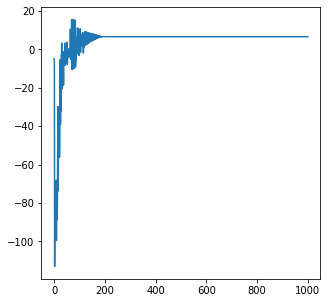

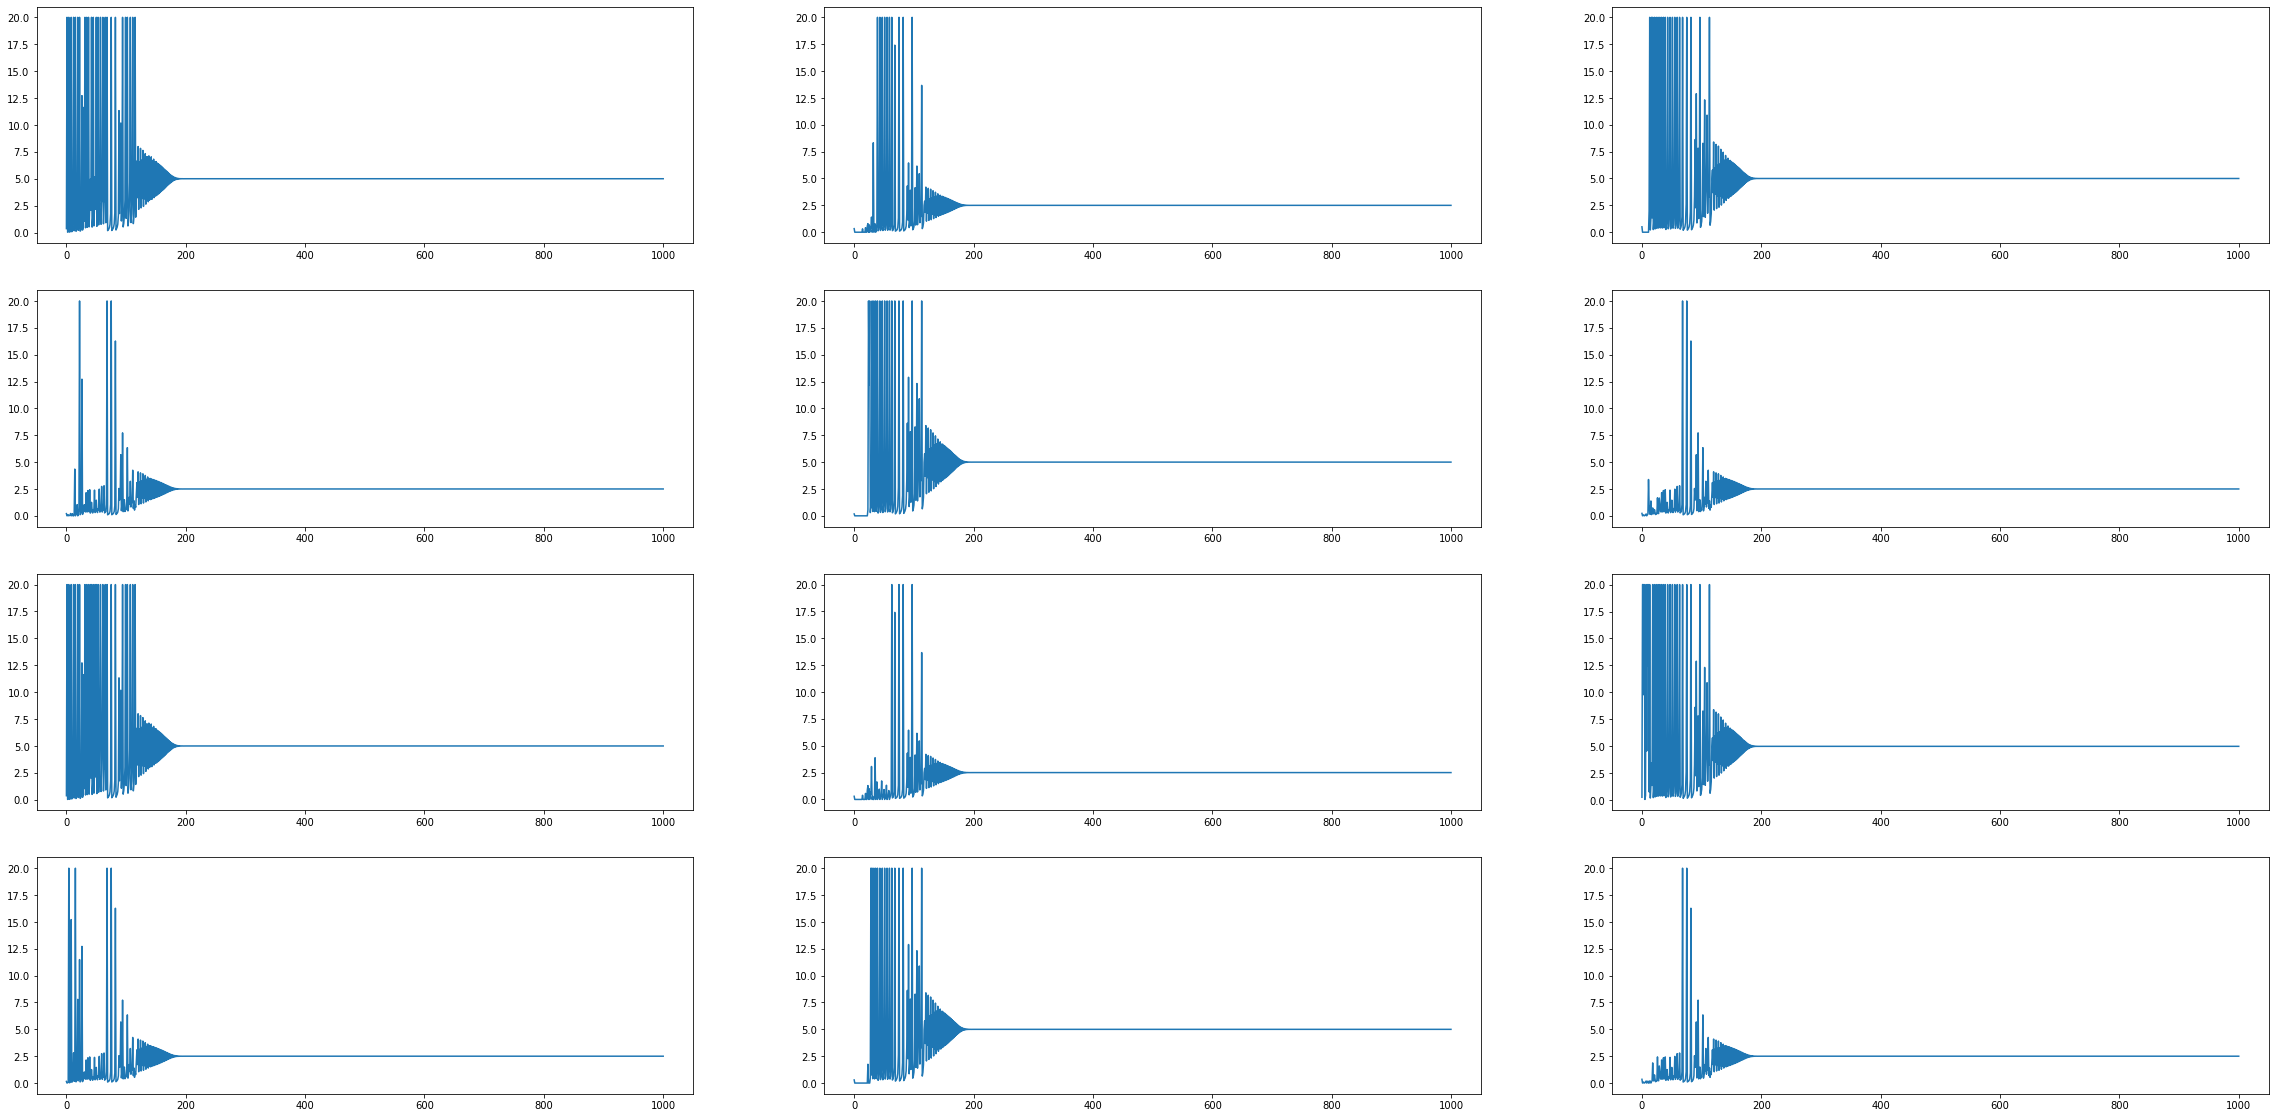

In [19]:
x = np.linspace(0,1000, 1000)
f2 = plt.figure()
f2.set_figwidth(5)
f2.set_figheight(5)
plt.plot(x,Y)
plt.show()

#plt.plot(x,y[:,0,1,0],y[:,0,1,1],y[:,0,2,0],y[:,0,2,1],y[:,1,2,0],y[:,1,2,1])
f = plt.figure()
f.set_figwidth(20/.5)
f.set_figheight(10/.5)
plt.subplot(4, 3, 1,)
plt.plot(x,y[:,0,1,0])
plt.subplot(4, 3, 2)
plt.plot(x,y[:,0,1,1])

plt.subplot(4, 3, 3)
plt.plot(x,y[:,0,2,0])

plt.subplot(4, 3, 4)
plt.plot(x,y[:,0,2,1])

plt.subplot(4, 3, 5)
plt.plot(x,y[:,1,2,0])


plt.subplot(4, 3, 6)
plt.plot(x,y[:,1,2,1])

plt.subplot(4, 3, 7)
plt.plot(x,y[:,1,0,0])
plt.subplot(4, 3, 8)
plt.plot(x,y[:,1,0,1])

plt.subplot(4, 3, 9)
plt.plot(x,y[:,2,0,0])

plt.subplot(4, 3, 10)
plt.plot(x,y[:,2,0,1])

plt.subplot(4, 3, 11)
plt.plot(x,y[:,2,1,0])


plt.subplot(4, 3, 12)
plt.plot(x,y[:,2,1,1])
plt.show()

In [ ]:
xstar=np.zeros([3,3,2]).reshape(3,3,2,1)
xstar

array([[[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]]],


       [[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]]],


       [[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]]]])